# Twitter Sentiment Analysis Classifier Training

On this notebook I'm colleting spanish data that was previously classified as Positive, Negative or Neutral. I then go ahead and use that data to train a TensorFlow deeb learning model using NLP data transformation tecniques. 

## Collecting and Loading the Data  

Data is contained in XML files from TASS-Taller de Analisis Semantico en la SEPLN.

In [ ]:
# imports
import pandas as pd
from xml.etree import ElementTree as ET

In [ ]:
# general function that takes an xml file and returns an ElementTree object which can be parsed in a dict-like fashion
def parse_xml(file_path):
  dom = ET.parse(file_path)
  return dom

In [ ]:
# dictionary that will hold the parsed xml 
tweets_dict = {
    "date": [],
    "tweet": [],
    "sentiment": [],
    "id": [],
    "user": [],
    "lang": []
}

In [ ]:
# specific TASS XML Schema function that parses through the dom and appends the data to the Dictionary.
def append_todict(dom):
    tweets = dom.findall('tweet')
    for tweet in tweets:
        tweets_dict['date'].append(tweet.find('date').text)
        tweets_dict['tweet'].append(tweet.find('content').text)
        try:
            tweets_dict['sentiment'].append(tweet.find('sentiment/polarity/value').text)
        except:
            tweets_dict['sentiment'].append(tweet.find('sentiments/polarity/value').text)
        tweets_dict['id'].append(tweet.find('tweetid').text)
        tweets_dict['user'].append(tweet.find('user').text)
        tweets_dict['lang'].append(tweet.find('lang').text)

In [ ]:
import os 
basedir = os.path.abspath(os.path.dirname('__file__'))
directory = os.path.join(basedir,'sourcedata')
for file in os.listdir(directory):
    if file.endswith(".xml"):
        file_directory = os.path.join(directory,file)
        try:
            dom = parse_xml(file_directory)
        except:
            dom = None
        if dom is None:
            print("Could not parse {}".format(file))
        else:
            append_todict(dom)
            print("File: {} added to dictionary successfully!".format(file))

File: 2012-general-train-tagged-3l.xml added to dictionary successfully!
File: 2019-TASS2019_country_CR_dev.xml added to dictionary successfully!
Could not parse TASS2019_country_PE_train.xml
File: 2019-TASS2019_country_ES_train.xml added to dictionary successfully!
File: 2019-TASS2019_country_UY_train.xml added to dictionary successfully!
File: 2019-TASS2019_country_MX_dev.xml added to dictionary successfully!
File: 2018-intertass-CR-development-tagged.xml added to dictionary successfully!
File: 2019-TASS2019_country_PE_train.xml added to dictionary successfully!
File: 2013-politics-test-tagged.xml added to dictionary successfully!
File: 2018-intertass-ES-train-tagged.xml added to dictionary successfully!
File: 2018-intertass-PE-development-tagged.xml added to dictionary successfully!
File: 2019-TASS2019_country_UY_dev.xml added to dictionary successfully!
File: 2018-intertass-PE-train-tagged.xml added to dictionary successfully!
File: 2019-TASS2019_country_MX_train.xml added to dicti

In [ ]:
for column, values in tweets_dict.items():
    print(f"{column}:{len(values)}")

date:20517
tweet:20517
sentiment:20517
id:20517
user:20517
lang:20517


In [ ]:
df = pd.DataFrame(data=tweets_dict)
print(df.shape)
df.head()

(20517, 6)


,date,tweet,sentiment,id,user,lang
0,2011-12-02T00:47:55,"Salgo de #VeoTV , que día más largoooooo...",NONE,142389495503925248,ccifuentes,es
1,2011-12-02T00:49:40,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,142389933619945473,CarmendelRiego,es
2,2011-12-02T00:57:40,@marodriguezb Gracias MAR,P,142391947707940864,CarmendelRiego,es
3,2011-12-02T02:33:37,"Off pensando en el regalito Sinde, la que se v...",N,142416095012339712,mgilguerrero,es
4,2011-12-02T02:59:03,Conozco a alguien q es adicto al drama! Ja ja ...,P,142422495721562112,paurubio,es


In [ ]:
# random shuffling the rows
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,date,tweet,sentiment,id,user,lang
0,Tue Sep 13 07:26:05 +0000 2016,"@DrLMelchor Muy bueno lo de ""... y creemos una...",P,775596398465146880,3293916292,es
1,Tue Dec 27 13:33:42 +0000 2016,@jschiller27 yo tengo 4 años sin comer tamal. ...,NONE,813739636161998849,249526249,es
2,2012-02-27T05:32:38,Grande!! RT @DavidCacho: Lo único que siempre ...,N,173988888589770752,mrtfernandez,es
3,2012-03-24T12:26:08,¿Tiene sentido la política fiscal del Gobierno...,NEU,183515033890848768,iescolar,es
4,2012-03-29T07:01:42,"Título de la obra: ""Inspiración asiática o com...",P,185230226429706241,mjguemes,es


In [ ]:
df.sentiment.value_counts()

N       6864
P       6576
NONE    3980
NEU     3097
Name: sentiment, dtype: int64

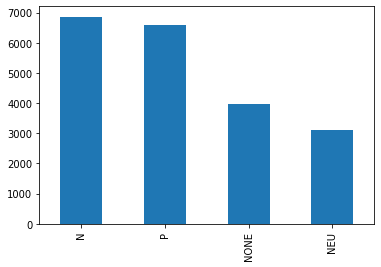

In [ ]:
df.sentiment.value_counts().plot(kind='bar')

As we can see there are many tweets where the sentiment is None... since the sentiment is a qualitative attribute of the text contained in the tweet it's not feasible to input values for those. I will treat those as missing values and just drop them out of the dataframe. (It is not time efficient to go through each None tweet and input the sentiment manually.

In [ ]:
filt = df['sentiment'] == 'NONE'
df_none = df[filt].reset_index(drop=True)
pd.options.display.max_colwidth = 200
df_none.loc[20:35, 'tweet']

20                                                                                                          Empieza esto! http://t.co/AcHBJHv0
21                                                                                                                                   Buenaaas.
22                                                     @AdriSerCal @UPyD @FVeiguela Os han mandado a la chica que nos cubría aqui! Que fuerte!
23      @Brendadema Hola Brenda, por favor envianos tu mail de usuario por MD para que veamos qué sucedió ya que la promo está activa Saludos.
24    Aveces cuando leo sus tuits y no entiendo algo, me dan ganas de preguntarles para entender mejor. Pero soy tímido y me quedo con la duda
25                                                                                                 http://t.co/4mgysYHz Q LLEGAMOS A MADRID!!!
26                                                           Siempre que estoy triste convierto ese sentimiento en cólera y sólo grito y grito

Upon exploring a few of the tweets we see some of them qualify as negative, Positive or Neutral. This confirms it is not efficient to go through them one by one. So I will just drop them indeed. 

Also... we will use a binary classifier so we will also drop the Neutral cases. 

In [ ]:
filt1 = df['sentiment'] != 'NONE'
filt2 = df['sentiment'] != 'NEU'
print(df[filt1 & filt2].shape)
df_clean = df[filt1 & filt2]
df_clean.head()

(13440, 6)


,date,tweet,sentiment,id,user,lang
0,Tue Sep 13 07:26:05 +0000 2016,"@DrLMelchor Muy bueno lo de ""... y creemos una Real Sociedad de Cientificos... Bueno, o Real o no!"". Muy de acuerdo con lo que dices",P,775596398465146880,3293916292,es
2,2012-02-27T05:32:38,Grande!! RT @DavidCacho: Lo único que siempre va a peor en este planeta es la situación en Oriente Próximo y la ceremonia de los Óscar...,N,173988888589770752,mrtfernandez,es
4,2012-03-29T07:01:42,"Título de la obra: ""Inspiración asiática o como quedarse sin tinta en el bic"" ;-) http://t.co/2VYxNpBK",P,185230226429706241,mjguemes,es
5,Tue Oct 11 13:36:11 +0000 2016,@RomanaFerrer Seguro que tienen miedo que llueva y se les mojen los datos,N,785836397571825664,35709180,es
8,Sat Dec 17 00:29:18 +0000 2016,#YSF2 @MundonickLA La mejor serie en todo el mundo !!!,P,809918358955184128,891311334,es


Great! we now have tweets on different topics such as politics and entertainment, and from different countries such as Spain, Peru and Costa Rica, which are labeled with Positive or Negative sentiment.  

Now let's save the dataframe int a training CSV and plot the distribution of the sentiment accross the data.

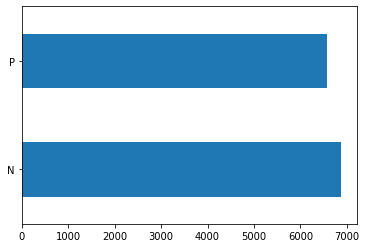

In [ ]:
#df_clean.to_csv('./sourcedata/training.csv', index=False)
df_clean.sentiment.value_counts().plot(kind='barh')

Selecting Train and Test Sets

In [ ]:
data = df_clean[['tweet', 'sentiment']].sample(frac=1).reset_index(drop=True)
data.head()

,tweet,sentiment
0,"Que dicha que la MLS ya se llevó a la %@+\×~¥ de Francisco Calvo, siempre me ha parecido insoportable",N
1,@cracks_oficial bueno felicidades por el millon de crack que hay en el canal !! soy un suscriptor ya un poco antiguo a por mas DE PERU,P
2,Se ha hecho el remolón...pero ha llegado y hasta suena bien:viernes 23 de diciembre!Hoy último programa de este 2011 de #losdesayunosdetve,P
3,@Laugamer721 Buenos Vídeos.Se que llegadas a los 1.000.000 de SUBS. Sigue haci y cuídate :v,P
4,Grupos radicales de izquierda mandan balas a Monti. http://t.co/6WpKFqBf Espero que la izquierda no caiga en la tentación de la violencia.,N


In [ ]:
# Replacing Positive with 1 and Negative with 0
data['sentiment'] = data['sentiment'].replace({'P':1, 'N':0})
data.sentiment.value_counts()

0    6864
1    6576
Name: sentiment, dtype: int64

In [ ]:
# Regular expression function to clean tweet
import re
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split())

data['tweet'] = data['tweet'].apply(clean_tweet)

In [ ]:
data.head()

,tweet,sentiment
0,Que dicha que la MLS ya se llev a la de Francisco Calvo siempre me ha parecido insoportable,0
1,oficial bueno felicidades por el millon de crack que hay en el canal soy un suscriptor ya un poco antiguo a por mas DE PERU,1
2,Se ha hecho el remol n pero ha llegado y hasta suena bien viernes 23 de diciembre Hoy ltimo programa de este 2011 de losdesayunosdetve,1
3,Buenos V deos Se que llegadas a los 1 000 000 de SUBS Sigue haci y cu date v,1
4,Grupos radicales de izquierda mandan balas a Monti Espero que la izquierda no caiga en la tentaci n de la violencia,0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['sentiment'], test_size=0.10, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12096,)
(1344,)
(12096,)
(1344,)


## Tokenizing

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
# Parameters for training:
vocab_size = 20000
embedding_dim = 64
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok,
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

In [ ]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

In [ ]:
training_padded[0]

array([3198,    7, 1170,   46, 1457, 1092,    6,   17,  401,    4,  393,
          3,  107, 6448,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Model Training and Testing

In [ ]:
# Bidirectional LSTM
max_features = 20000
maxlen = 200

inputs = keras.Input(shape=(None,), dtype='int32')
x = layers.Embedding(max_features, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile("adam", "binary_crossentropy", metrics=['accuracy'])
history = model.fit(training_padded, training_labels, batch_size=32, epochs=2, validation_data=(testing_padded, testing_labels))

Epoch 1/2
378/378 [==============================] - 169s 448ms/step - loss: 0.5239 - accuracy: 0.7340 - val_loss: 0.4263 - val_accuracy: 0.8058
Epoch 2/2
378/378 [==============================] - 168s 445ms/step - loss: 0.2332 - accuracy: 0.9101 - val_loss: 0.4329 - val_accuracy: 0.8147


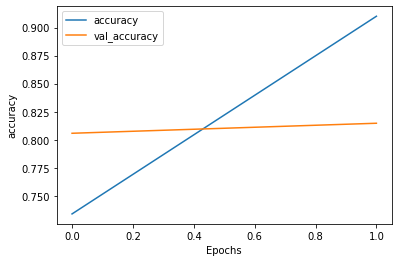

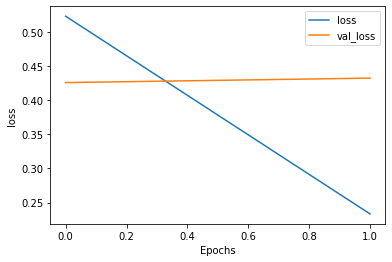

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Testing Predictions

In [ ]:
sentence =['RT @ovi3i: Información de último minutos, Luis Abinader arriba del Penco...🇩🇴🇩🇴🇩🇴 https://t.co/cIh5UoXZ8e', 
       'RT @VladimirVargasM: #ATENCIONPAIS #TVMCTV "El fraude ya está montado en RD" Por Bolivar Balcacer Si el PRM, Luis Abinader y José Paliza…',
       'RT @JuanJoseEncarn3: El PLD pierde en primera vuelta mucho a poco, Luis Abinader, primera vuelta 58.7 % y 32 senadores PRM y aliados . http…',
       'Hasta que consigas experiencia trabaja en tu productividad.', 
       'Ayer comi papas con huevo, un poco de arroz y queso.', 
       'Me encanta como piensa Luis, es el mejor candidato']
cleaned_sentence = [clean_tweet(x) for x in sentence]
sequences = tokenizer.texts_to_sequences(cleaned_sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.19382265]
 [0.3588924 ]
 [0.05236128]
 [0.65720063]
 [0.5389497 ]
 [0.9317991 ]]


In [ ]:
for x in model.predict(padded):
    print(f"Score: {x}")

Score: [0.19382265]
Score: [0.3588924]
Score: [0.05236128]
Score: [0.65720063]
Score: [0.5389497]
Score: [0.9317991]


### Saving Model and tokenizer for production use

In [ ]:
model.save('my_model.h5')

In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)